<a href="https://colab.research.google.com/github/akashsingh062/UIDAI-Hackathon/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

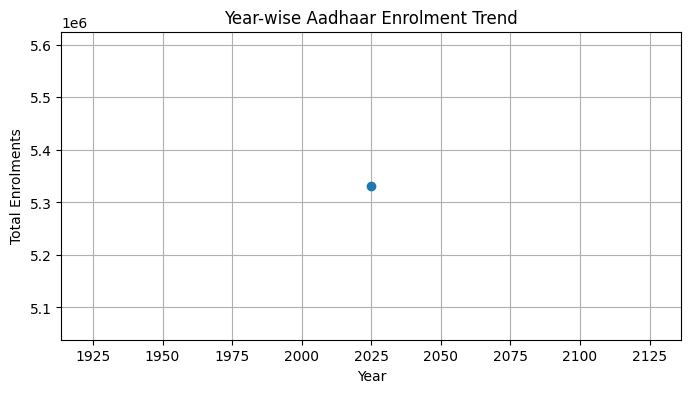

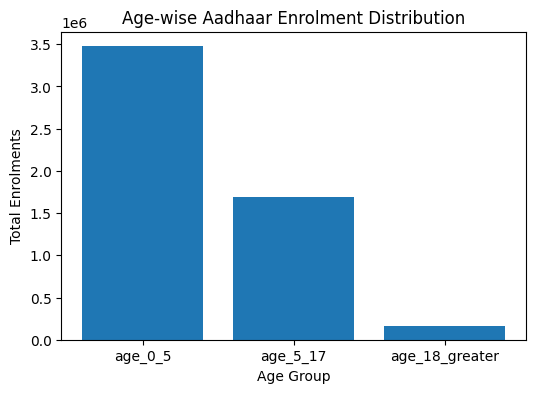

Top 10 States by Total Enrolment:
state
Uttar Pradesh     1002631.0
Bihar              593753.0
Madhya Pradesh     487892.0
West Bengal        369217.0
Maharashtra        363446.0
Rajasthan          340591.0
Gujarat            275042.0
Assam              225359.0
Karnataka          219618.0
Tamil Nadu         215710.0
Name: total_enrolment, dtype: float64

Top 10 Districts by Enrolment:
state          district         
Maharashtra    Thane                43142.0
Bihar          Sitamarhi            41652.0
Uttar Pradesh  Bahraich             38897.0
West Bengal    Murshidabad          34968.0
               South 24 Parganas    33090.0
Maharashtra    Pune                 31148.0
Karnataka      Bengaluru            30657.0
Uttar Pradesh  Sitapur              30475.0
Rajasthan      Jaipur               30341.0
Bihar          West Champaran       29913.0
Name: total_enrolment, dtype: float64

Bottom 10 Districts by Enrolment (Non-zero):
state                      district     
Rajasthan   

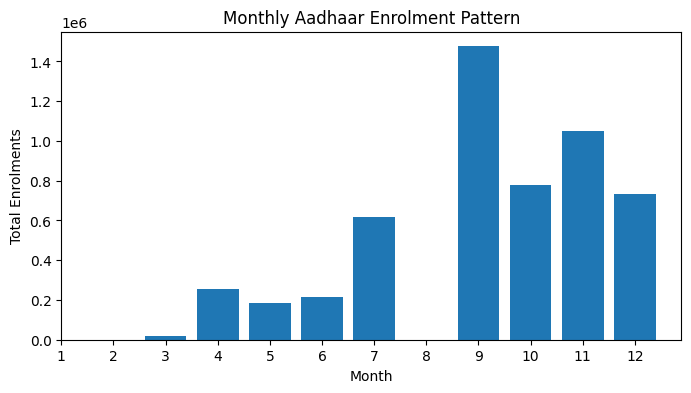

In [4]:
# ===============================
# Aadhaar Enrolment – Clean EDA
# ===============================

import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dataset
# -------------------------------
df = pd.read_csv("/content/Untitled Folder/dataSet/cleaned_data.csv")

# -------------------------------
# 2. Correct data types
# -------------------------------

# Parse date (AUTO detects YYYY-MM-DD)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convert age columns to numeric
age_cols = ['age_0_5', 'age_5_17', 'age_18_greater']
df[age_cols] = df[age_cols].apply(pd.to_numeric, errors='coerce')

# Drop invalid rows
df = df.dropna(subset=['date'] + age_cols)

# -------------------------------
# 3. Feature engineering
# -------------------------------

# Total enrolment
df['total_enrolment'] = df[age_cols].sum(axis=1)

# Time features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Drop rows with bad time values
df = df.dropna(subset=['year', 'month', 'total_enrolment'])

# -------------------------------
# 4. Year-wise Enrolment Trend
# -------------------------------
yearly = df.groupby('year')['total_enrolment'].sum()

plt.figure(figsize=(8,4))
plt.plot(yearly.index, yearly.values, marker='o')
plt.title("Year-wise Aadhaar Enrolment Trend")
plt.xlabel("Year")
plt.ylabel("Total Enrolments")
plt.grid(True)
plt.show()

# -------------------------------
# 5. Age-wise Enrolment Distribution
# -------------------------------
age_summary = df[age_cols].sum()

plt.figure(figsize=(6,4))
plt.bar(age_summary.index, age_summary.values)
plt.title("Age-wise Aadhaar Enrolment Distribution")
plt.xlabel("Age Group")
plt.ylabel("Total Enrolments")
plt.show()

# -------------------------------
# 6. State-wise Total Enrolment
# -------------------------------
state_enrolment = (
    df.groupby('state')['total_enrolment']
    .sum()
    .sort_values(ascending=False)
)

print("Top 10 States by Total Enrolment:")
print(state_enrolment.head(10))

# -------------------------------
# 7. District-level Analysis
# -------------------------------
district_enrolment = (
    df.groupby(['state', 'district'])['total_enrolment']
    .sum()
    .sort_values(ascending=False)
)

print("\nTop 10 Districts by Enrolment:")
print(district_enrolment.head(10))

print("\nBottom 10 Districts by Enrolment (Non-zero):")
print(district_enrolment[district_enrolment > 0].tail(10))

# -------------------------------
# 8. Adult (18+) Enrolment by State
# -------------------------------
adult_state = (
    df.groupby('state')['age_18_greater']
    .sum()
    .sort_values(ascending=False)
)

print("\nTop 10 States by Adult (18+) Enrolment:")
print(adult_state.head(10))

# -------------------------------
# 9. Monthly Enrolment Pattern
# -------------------------------
monthly = df.groupby('month')['total_enrolment'].sum().sort_index()

plt.figure(figsize=(8,4))
plt.bar(monthly.index, monthly.values)
plt.title("Monthly Aadhaar Enrolment Pattern")
plt.xlabel("Month")
plt.ylabel("Total Enrolments")
plt.xticks(range(1,13))
plt.show()

In [5]:
# =====================================
# ANOMALY DETECTION – FINAL CLEAN CODE
# =====================================

import numpy as np

# -------------------------------
# 1. District-level anomalies (Global)
# -------------------------------

district_totals = (
    df.groupby(['state', 'district'])['total_enrolment']
    .sum()
    .reset_index()
)

# IQR method
q1 = district_totals['total_enrolment'].quantile(0.25)
q3 = district_totals['total_enrolment'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

district_totals['global_anomaly'] = district_totals['total_enrolment'].apply(
    lambda x: 'Low' if x < lower_bound else ('High' if x > upper_bound else 'Normal')
)

global_anomalies = district_totals[
    district_totals['global_anomaly'] != 'Normal'
]

print("Global District Anomalies:")
print(global_anomalies)

# -------------------------------
# 2. Very low enrolment districts
# -------------------------------

low_enrolment_districts = district_totals[
    district_totals['total_enrolment'] <= 5
].sort_values('total_enrolment')

print("\nLow Enrolment Districts (≤5):")
print(low_enrolment_districts)

# -------------------------------
# 3. State-relative anomalies (Z-score)
# -------------------------------

state_stats = (
    district_totals
    .groupby('state')['total_enrolment']
    .agg(mean='mean', std='std')
    .reset_index()
)

district_state = district_totals.merge(state_stats, on='state')

# Avoid division by zero
district_state['std'] = district_state['std'].replace(0, np.nan)

district_state['z_score'] = (
    (district_state['total_enrolment'] - district_state['mean']) /
    district_state['std']
)

state_relative_anomalies = district_state[
    district_state['z_score'].abs() > 2
].sort_values('z_score', ascending=False)

print("\nState-relative District Anomalies (|z| > 2):")
print(state_relative_anomalies)

# -------------------------------
# 4. Adult (18+) enrolment anomalies
# -------------------------------

adult_state = (
    df.groupby('state')['age_18_greater']
    .sum()
    .reset_index()
)

q1_adult = adult_state['age_18_greater'].quantile(0.25)
q3_adult = adult_state['age_18_greater'].quantile(0.75)
iqr_adult = q3_adult - q1_adult

adult_state['adult_anomaly'] = adult_state['age_18_greater'].apply(
    lambda x: 'High' if x > q3_adult + 1.5 * iqr_adult else 'Normal'
)

adult_anomalies = adult_state[
    adult_state['adult_anomaly'] == 'High'
]

print("\nAdult (18+) Enrolment Anomalies:")
print(adult_anomalies)

Global District Anomalies:
            state           district  total_enrolment global_anomaly
84          Assam             Cachar          17211.0           High
124         Bihar          Bhagalpur          20596.0           High
128         Bihar     East Champaran          28779.0           High
129         Bihar               Gaya          26760.0           High
139         Bihar          Madhubani          25390.0           High
...           ...                ...              ...            ...
1027  West Bengal              Nadia          17535.0           High
1028  West Bengal  North 24 Parganas          28220.0           High
1032  West Bengal  Paschim Medinipur          17757.0           High
1038  West Bengal  South 24 Parganas          33090.0           High
1041  West Bengal     Uttar Dinajpur          26445.0           High

[66 rows x 4 columns]

Low Enrolment Districts (≤5):
                          state            district  total_enrolment  \
2     Andaman & Nic

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# --------------------------------
# Create district-level dataset
# --------------------------------
district_ml = (
    df.groupby(['state', 'district'])[['age_0_5', 'age_5_17', 'age_18_greater', 'total_enrolment']]
    .sum()
    .reset_index()
)

# Remove zero-enrolment districts (safety)
district_ml = district_ml[district_ml['total_enrolment'] > 0]

# Percentage features
district_ml['pct_0_5'] = district_ml['age_0_5'] / district_ml['total_enrolment']
district_ml['pct_5_17'] = district_ml['age_5_17'] / district_ml['total_enrolment']
district_ml['pct_18_plus'] = district_ml['age_18_greater'] / district_ml['total_enrolment']

# ML feature matrix
X = district_ml[['total_enrolment', 'pct_0_5', 'pct_5_17', 'pct_18_plus']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
district_ml['cluster'] = kmeans.fit_predict(X_scaled)

# --------------------------------
# Cluster interpretation
# --------------------------------
cluster_summary = (
    district_ml
    .groupby('cluster')[['total_enrolment', 'pct_0_5', 'pct_5_17', 'pct_18_plus']]
    .mean()
)

print("Cluster Summary:")
print(cluster_summary)

# Dynamic cluster labeling (IMPORTANT)
sorted_clusters = cluster_summary.sort_values('total_enrolment')

cluster_labels = {
    sorted_clusters.index[0]: 'Low Demand / Sparse Districts',
    sorted_clusters.index[1]: 'Medium Demand / Stable Districts',
    sorted_clusters.index[2]: 'High Demand / Hotspot Districts'
}

district_ml['cluster_label'] = district_ml['cluster'].map(cluster_labels)

# --------------------------------
# Results
# --------------------------------

# District count per cluster
print("\nDistricts per cluster:")
print(district_ml['cluster_label'].value_counts())

# Sample high-demand districts
print("\nTop High-Demand Districts:")
print(
    district_ml[district_ml['cluster_label'] == 'High Demand / Hotspot Districts']
    .sort_values('total_enrolment', ascending=False)
    .head(10)
)

Cluster Summary:
         total_enrolment   pct_0_5  pct_5_17  pct_18_plus
cluster                                                  
0            3058.132018  0.840483  0.146429     0.013088
1            9205.285714  0.513735  0.455979     0.030286
2            3698.558140  0.315643  0.373166     0.311191

Districts per cluster:
cluster_label
Low Demand / Sparse Districts       659
High Demand / Hotspot Districts     343
Medium Demand / Stable Districts     43
Name: count, dtype: int64

Top High-Demand Districts:
              state           district  age_0_5  age_5_17  age_18_greater  \
567     Maharashtra              Thane  28692.0   13492.0           958.0   
159           Bihar          Sitamarhi  20358.0   18600.0          2694.0   
898   Uttar Pradesh           Bahraich  14491.0   22132.0          2274.0   
1026    West Bengal        Murshidabad  30593.0    4290.0            85.0   
1038    West Bengal  South 24 Parganas  24661.0    8125.0           304.0   
558     Maharashtra

In [7]:
# =========================================
# Aadhaar Enrolment Priority Index
# =========================================

# STEP 1: Aggregate PIN-code → District
df_district = (
    df
    .groupby(["state", "district"], as_index=False)
    .agg({
        "age_0_5": "sum",
        "age_5_17": "sum",
        "age_18_greater": "sum"
    })
)

# STEP 2: Total & percentages
df_district["total_enrolment"] = (
    df_district["age_0_5"] +
    df_district["age_5_17"] +
    df_district["age_18_greater"]
)

df_district["pct_0_5"] = df_district["age_0_5"] / df_district["total_enrolment"]
df_district["pct_5_17"] = df_district["age_5_17"] / df_district["total_enrolment"]
df_district["pct_18_plus"] = df_district["age_18_greater"] / df_district["total_enrolment"]

# STEP 3: Priority components
IDEAL_CHILD_SHARE = 0.40

df_district["child_share"] = (
    df_district["pct_0_5"] + df_district["pct_5_17"]
)

df_district["child_enrolment_gap"] = np.maximum(
    0, IDEAL_CHILD_SHARE - df_district["child_share"]
)

df_district["overall_gap"] = 1 / (df_district["total_enrolment"] + 1)
df_district["adult_imbalance"] = df_district["pct_18_plus"]

# STEP 4: Normalize
scaler = MinMaxScaler()
gap_features = [
    "child_enrolment_gap",
    "overall_gap",
    "adult_imbalance"
]
df_district[gap_features] = scaler.fit_transform(df_district[gap_features])

# STEP 5: Priority Index
df_district["priority_index"] = (
    0.5 * df_district["child_enrolment_gap"] +
    0.3 * df_district["overall_gap"] +
    0.2 * df_district["adult_imbalance"]
)

# STEP 6: Rank & label
df_district["priority_rank"] = df_district["priority_index"].rank(
    ascending=False, method="dense"
)

q1 = df_district["priority_index"].quantile(0.50)
q2 = df_district["priority_index"].quantile(0.80)

df_district["priority_label"] = df_district["priority_index"].apply(
    lambda x: "High Priority" if x >= q2 else
              "Medium Priority" if x >= q1 else
              "Low Priority"
)

# STEP 7: Final output
priority_output = df_district[
    [
        "state",
        "district",
        "priority_index",
        "priority_rank",
        "priority_label",
        "pct_0_5",
        "pct_5_17",
        "pct_18_plus"
    ]
].sort_values("priority_rank")

priority_output.head(10)

,state,district,priority_index,priority_rank,priority_label,pct_0_5,pct_5_17,pct_18_plus
0,100000,100000,0.702777,1.0,High Priority,0.0,0.004673,0.995327
2,Andaman & Nicobar Islands,Nicobars,0.300000,2.0,High Priority,1.0,0.000000,0.000000
1013,West Bengal,Hooghiy,0.300000,2.0,High Priority,1.0,0.000000,0.000000
1010,West Bengal,East Midnapur,0.300000,2.0,High Priority,1.0,0.000000,0.000000
897,Uttar Pradesh,Bagpat,0.300000,2.0,High Priority,0.0,1.000000,0.000000
829,Tamil Nadu,Tiruvarur,0.300000,2.0,High Priority,1.0,0.000000,0.000000
773,Rajasthan,Salumbar,0.300000,2.0,High Priority,1.0,0.000000,0.000000
808,Tamil Nadu,Namakkal *,0.300000,2.0,High Priority,0.0,1.000000,0.000000
739,Rajasthan,Balotra,0.300000,2.0,High Priority,1.0,0.000000,0.000000
743,Rajasthan,Beawar,0.300000,2.0,High Priority,1.0,0.000000,0.000000


In [8]:
# =========================================
# STEP 9: Demand Forecasting & Resource Planning
# =========================================

import pandas as pd
import numpy as np

# -------------------------------------------------
# ASSUMPTION:
# You still have original PIN-level dataframe: df
# with columns: date, state, district, age_0_5, age_5_17, age_18_greater
# -------------------------------------------------

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"])

# -------------------------------------------------
# STEP 1: Monthly enrolment aggregation (district)
# -------------------------------------------------
df["monthly_enrolment"] = (
    df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]
)

monthly_district = (
    df
    .groupby([pd.Grouper(key="date", freq="M"), "state", "district"], as_index=False)
    .agg({"monthly_enrolment": "sum"})
)

# -------------------------------------------------
# STEP 2: Simple 3-month demand forecast
# (Moving Average – practical & explainable)
# -------------------------------------------------
forecast_list = []

for (state, district), grp in monthly_district.groupby(["state", "district"]):
    grp = grp.sort_values("date")

    if len(grp) >= 3:
        forecast = grp["monthly_enrolment"].tail(3).mean()
    else:
        forecast = grp["monthly_enrolment"].mean()

    forecast_list.append({
        "state": state,
        "district": district,
        "forecast_next_month": round(forecast)
    })

forecast_df = pd.DataFrame(forecast_list)

# -------------------------------------------------
# STEP 3: Resource estimation logic
# -------------------------------------------------
# Assumptions (clearly defensible)
ENROLMENTS_PER_OPERATOR_PER_DAY = 25
WORKING_DAYS_PER_MONTH = 22

forecast_df["required_staff"] = (
    forecast_df["forecast_next_month"] /
    (ENROLMENTS_PER_OPERATOR_PER_DAY * WORKING_DAYS_PER_MONTH)
).apply(np.ceil).astype(int)

forecast_df["required_kits"] = forecast_df["required_staff"]

# -------------------------------------------------
# STEP 4: Merge with Priority Index
# -------------------------------------------------
final_plan = priority_output.merge(
    forecast_df,
    on=["state", "district"],
    how="left"
)

# -------------------------------------------------
# STEP 5: Final actionable output
# -------------------------------------------------
final_plan = final_plan[
    [
        "state",
        "district",
        "priority_label",
        "priority_rank",
        "forecast_next_month",
        "required_staff",
        "required_kits"
    ]
].sort_values("priority_rank")

final_plan.head(10)

/tmp/ipython-input-2432583059.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key="date", freq="M"), "state", "district"], as_index=False)


,state,district,priority_label,priority_rank,forecast_next_month,required_staff,required_kits
0,100000,100000,High Priority,1.0,67,1,1
1,Andaman & Nicobar Islands,Nicobars,High Priority,2.0,1,1,1
2,West Bengal,Hooghiy,High Priority,2.0,1,1,1
3,West Bengal,East Midnapur,High Priority,2.0,1,1,1
4,Uttar Pradesh,Bagpat,High Priority,2.0,1,1,1
9,Rajasthan,Beawar,High Priority,2.0,1,1,1
6,Rajasthan,Salumbar,High Priority,2.0,1,1,1
10,Orissa,Sundergarh,High Priority,2.0,1,1,1
14,Haryana,Jhajjar *,High Priority,2.0,1,1,1
13,Jammu & Kashmir,Punch,High Priority,2.0,1,1,1


Total High Priority Districts: 209


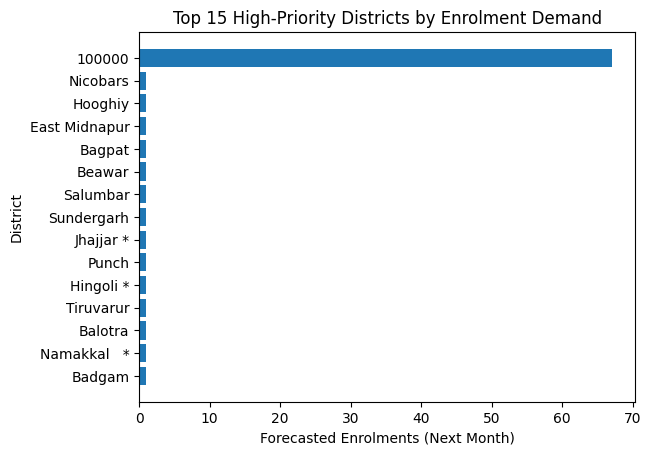

✅ Files exported successfully


In [9]:
# =========================================
# STEP 10: Actionable Insights & Visualization
# =========================================

import matplotlib.pyplot as plt

# -------------------------------------------------
# STEP 1: Focus only on HIGH PRIORITY districts
# -------------------------------------------------
high_priority = final_plan[
    final_plan["priority_label"] == "High Priority"
].copy()

print("Total High Priority Districts:", len(high_priority))
high_priority.head(10)

# -------------------------------------------------
# STEP 2: Top 15 districts needing immediate action
# -------------------------------------------------
top15 = high_priority.sort_values("priority_rank").head(15)

# -------------------------------------------------
# STEP 3: Bar chart – Forecasted Enrolment Demand
# -------------------------------------------------
plt.figure()
plt.barh(
    top15["district"],
    top15["forecast_next_month"]
)
plt.xlabel("Forecasted Enrolments (Next Month)")
plt.ylabel("District")
plt.title("Top 15 High-Priority Districts by Enrolment Demand")
plt.gca().invert_yaxis()
plt.show()

# -------------------------------------------------
# STEP 4: Resource requirement summary (policy view)
# -------------------------------------------------
resource_summary = high_priority.groupby("state").agg(
    total_districts=("district", "count"),
    total_staff_required=("required_staff", "sum"),
    total_kits_required=("required_kits", "sum")
).reset_index()

resource_summary.sort_values("total_staff_required", ascending=False).head(10)

# -------------------------------------------------
# STEP 5: Export outputs (for dashboard / submission)
# -------------------------------------------------
final_plan.to_csv("district_priority_resource_plan.csv", index=False)
high_priority.to_csv("high_priority_districts.csv", index=False)
resource_summary.to_csv("state_resource_summary.csv", index=False)

print("✅ Files exported successfully")

Outlier upper cap: 592.0


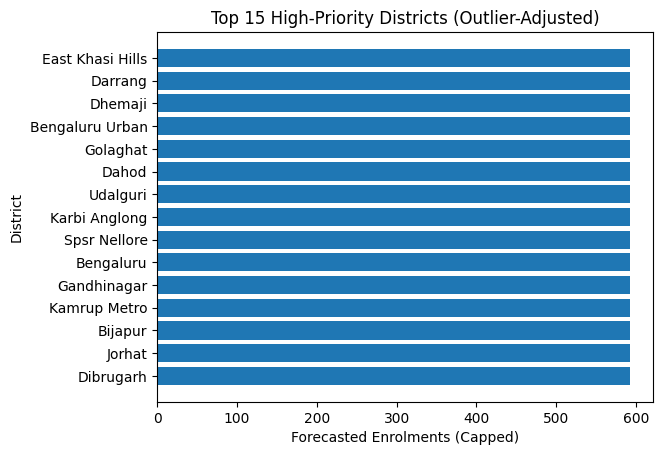

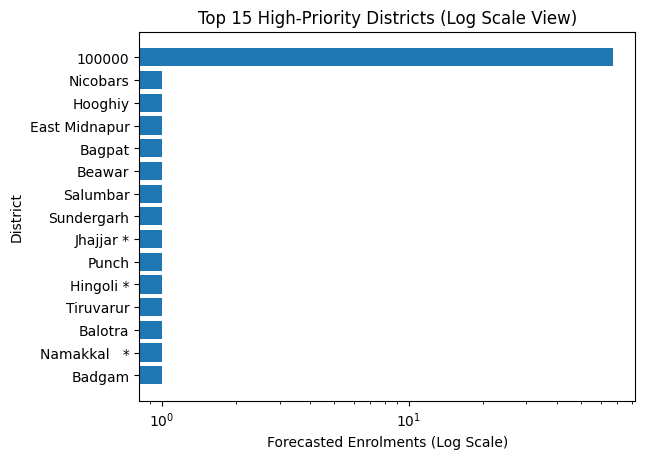

✅ Outliers handled & refined outputs saved


In [10]:
# =========================================
# STEP 11: Outlier Handling & Better Insights
# =========================================

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# STEP 1: Detect outliers using IQR method
# -------------------------------------------------
q1 = high_priority["forecast_next_month"].quantile(0.25)
q3 = high_priority["forecast_next_month"].quantile(0.75)
iqr = q3 - q1

upper_cap = q3 + 1.5 * iqr

print("Outlier upper cap:", upper_cap)

# -------------------------------------------------
# STEP 2: Cap extreme values (policy-safe)
# -------------------------------------------------
high_priority["forecast_capped"] = np.where(
    high_priority["forecast_next_month"] > upper_cap,
    upper_cap,
    high_priority["forecast_next_month"]
)

# -------------------------------------------------
# STEP 3: Re-plot Top 15 with capped values
# -------------------------------------------------
top15_capped = (
    high_priority
    .sort_values("forecast_capped", ascending=False)
    .head(15)
)

plt.figure()
plt.barh(
    top15_capped["district"],
    top15_capped["forecast_capped"]
)
plt.xlabel("Forecasted Enrolments (Capped)")
plt.ylabel("District")
plt.title("Top 15 High-Priority Districts (Outlier-Adjusted)")
plt.gca().invert_yaxis()
plt.show()

# -------------------------------------------------
# STEP 4: Optional log-scale visualization
# -------------------------------------------------
plt.figure()
plt.barh(
    top15["district"],
    top15["forecast_next_month"]
)
plt.xscale("log")
plt.xlabel("Forecasted Enrolments (Log Scale)")
plt.ylabel("District")
plt.title("Top 15 High-Priority Districts (Log Scale View)")
plt.gca().invert_yaxis()
plt.show()

# -------------------------------------------------
# STEP 5: Save refined output
# -------------------------------------------------
high_priority_refined = high_priority.drop(columns=["forecast_capped"], errors="ignore")
high_priority_refined.to_csv("high_priority_districts_refined.csv", index=False)

print("✅ Outliers handled & refined outputs saved")

In [11]:
# =========================================
# STEP 12: Policy Action Recommendation Engine
# =========================================

import numpy as np

# -------------------------------------------------
# STEP 1: Copy high priority data
# -------------------------------------------------
policy_df = high_priority.copy()

# -------------------------------------------------
# STEP 2: Define action rules
# -------------------------------------------------
def recommend_action(row):
    demand = row["forecast_next_month"]

    if demand >= 300:
        return "Intensive Enrollment Drive (7 days)"
    elif demand >= 100:
        return "Special Enrollment Camp (3 days)"
    elif demand >= 30:
        return "Mobile Enrollment Unit"
    else:
        return "Routine Monitoring"

policy_df["recommended_action"] = policy_df.apply(recommend_action, axis=1)

# -------------------------------------------------
# STEP 3: Deployment intensity score
# -------------------------------------------------
policy_df["deployment_intensity"] = np.where(
    policy_df["forecast_next_month"] >= 300, "Very High",
    np.where(
        policy_df["forecast_next_month"] >= 100, "High",
        np.where(
            policy_df["forecast_next_month"] >= 30, "Medium",
            "Low"
        )
    )
)

# -------------------------------------------------
# STEP 4: Final policy-ready output
# -------------------------------------------------
policy_output = policy_df[
    [
        "state",
        "district",
        "priority_rank",
        "forecast_next_month",
        "required_staff",
        "required_kits",
        "recommended_action",
        "deployment_intensity"
    ]
].sort_values("priority_rank")

policy_output.head(15)

,state,district,priority_rank,forecast_next_month,required_staff,required_kits,recommended_action,deployment_intensity
0,100000,100000,1.0,67,1,1,Mobile Enrollment Unit,Medium
1,Andaman & Nicobar Islands,Nicobars,2.0,1,1,1,Routine Monitoring,Low
2,West Bengal,Hooghiy,2.0,1,1,1,Routine Monitoring,Low
3,West Bengal,East Midnapur,2.0,1,1,1,Routine Monitoring,Low
4,Uttar Pradesh,Bagpat,2.0,1,1,1,Routine Monitoring,Low
9,Rajasthan,Beawar,2.0,1,1,1,Routine Monitoring,Low
6,Rajasthan,Salumbar,2.0,1,1,1,Routine Monitoring,Low
10,Orissa,Sundergarh,2.0,1,1,1,Routine Monitoring,Low
14,Haryana,Jhajjar *,2.0,1,1,1,Routine Monitoring,Low
13,Jammu & Kashmir,Punch,2.0,1,1,1,Routine Monitoring,Low


In [13]:
# =========================================
# FIXED STEP 13: Child-Focused Policy Refinement
# =========================================

# Merge percentage columns back from district-level data
policy_refined = policy_output.merge(
    df_district[
        [
            "state",
            "district",
            "pct_0_5",
            "pct_5_17"
        ]
    ],
    on=["state", "district"],
    how="left"
)

# -------------------------------------------------
# STEP 1: Child enrolment share
# -------------------------------------------------
policy_refined["child_share"] = (
    policy_refined["pct_0_5"] + policy_refined["pct_5_17"]
)

# -------------------------------------------------
# STEP 2: Refined policy action logic
# -------------------------------------------------
def refined_action(row):
    demand = row["forecast_next_month"]
    child_share = row["child_share"]

    if demand >= 100:
        return "Special Enrollment Camp (3 days)"
    if child_share < 0.15:
        return "Child-Focused Awareness + Mobile Unit"
    if child_share < 0.30:
        return "School & Anganwadi Enrollment Drive"
    return "Routine Monitoring"

policy_refined["recommended_action"] = policy_refined.apply(
    refined_action, axis=1
)

# -------------------------------------------------
# STEP 3: Policy reason (explainability)
# -------------------------------------------------
def policy_reason(row):
    if row["forecast_next_month"] >= 100:
        return "High Expected Demand"
    if row["child_share"] < 0.15:
        return "Severe Child Enrolment Gap"
    if row["child_share"] < 0.30:
        return "Moderate Child Enrolment Gap"
    return "Stable Enrolment"

policy_refined["policy_reason"] = policy_refined.apply(
    policy_reason, axis=1
)

# -------------------------------------------------
# STEP 4: Final output
# -------------------------------------------------
final_policy_output = policy_refined[
    [
        "state",
        "district",
        "priority_rank",
        "forecast_next_month",
        "required_staff",
        "recommended_action",
        "policy_reason"
    ]
].sort_values("priority_rank")

final_policy_output.head(15)

,state,district,priority_rank,forecast_next_month,required_staff,recommended_action,policy_reason
0,100000,100000,1.0,67,1,Child-Focused Awareness + Mobile Unit,Severe Child Enrolment Gap
1,Andaman & Nicobar Islands,Nicobars,2.0,1,1,Routine Monitoring,Stable Enrolment
2,West Bengal,Hooghiy,2.0,1,1,Routine Monitoring,Stable Enrolment
3,West Bengal,East Midnapur,2.0,1,1,Routine Monitoring,Stable Enrolment
4,Uttar Pradesh,Bagpat,2.0,1,1,Routine Monitoring,Stable Enrolment
5,Rajasthan,Beawar,2.0,1,1,Routine Monitoring,Stable Enrolment
6,Rajasthan,Salumbar,2.0,1,1,Routine Monitoring,Stable Enrolment
7,Orissa,Sundergarh,2.0,1,1,Routine Monitoring,Stable Enrolment
8,Haryana,Jhajjar *,2.0,1,1,Routine Monitoring,Stable Enrolment
9,Jammu & Kashmir,Punch,2.0,1,1,Routine Monitoring,Stable Enrolment


In [14]:
final_policy_output.to_csv(
    "UIDAI_Final_Policy_Recommendations.csv",
    index=False
)